# Weak/Integral SINDy Feature Overview
It is often difficult to identify dynamical systems in the presence of substantial noise. Towards that end, a number of publications have used SINDy to identify the weak-formulation (integral formulation) of the system of ODEs or PDEs. This allows one to avoid taking high-order derivatives of noisy data (high-order derivatives of noisy data will amplify the noise). 

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.6?filepath=examples/12_weakform_SINDy_examples.ipynb)

In [1]:
import timeit
start=timeit.default_timer()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz
from pysindy.utils import convert_u_dot_integral

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Test weak form ODE functionality on Lorenz equation

In [3]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    num_pts_per_domain=100,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, 
    thresholder="l1", 
    max_iter=1000, 
    normalize_columns=True, 
    tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train)
model.print()


(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0x2
(x2)' = -2.667 x2 + 1.000 x0x1


/Users/zack/Desktop/temp/pysindy/pysindy/optimizers/sr3.py:388: ConvergenceWarning: SR3._reduce did not converge after 1000 iterations.
  warnings.warn(


Performance should improve as the number of sub-domain integrations points increases (numerically approximating the integrals better and better) and number of sub-domains increases (more points for regression). Let's use some noisy Lorenz data and investigate.

In [4]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
u_test = solve_ivp(lorenz, t_train_span, u0_test, 
                   t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)  # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)  # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n, n))
pts_scan = np.linspace(4, 40, n, dtype=int)
K_scan = np.linspace(20, 300, n, dtype=int)
for i, K in enumerate(K_scan):
    for j, pts in enumerate(pts_scan):
        ode_lib = ps.WeakPDELibrary(
            library_functions=library_functions,
            function_names=library_function_names,
            spatiotemporal_grid=t_train,
            include_bias=True,
            is_uniform=True,
            num_pts_per_domain=pts,
            K=K,
        )
        opt = ps.SR3(
            threshold=0.05,
            thresholder="l0",
            max_iter=1000,
            normalize_columns=True,
            tol=1e-10,
        )
        u_dot_train_integral = convert_u_dot_integral(u_train, ode_lib)

        # Instantiate and fit the SINDy model with the integral of u_dot
        model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
        model.fit(u_train, quiet=True)
        errs[i, j] = np.sqrt(
            (
                np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2)
                / np.sum(u_dot_train_integral ** 2)
            )
            / u_dot_train_integral.shape[0]
        )

Performance clearly improves as the number of subdomains and number of integrations points increase! We can also see that Lorenz is correctly identified despite ~20% noise levels.


The plot belows shows that we can use the weak-formulation to build models that are robust to noise, and additionally indicates convergence as the regression becomes larger and more accurate. 

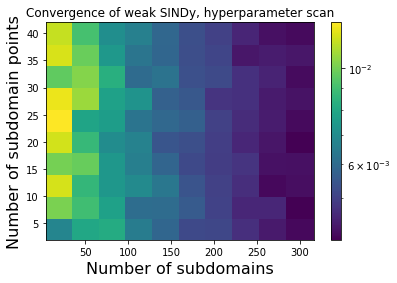

In [5]:
from matplotlib.colors import LogNorm

plt.pcolor(K_scan, pts_scan, errs.T, norm=LogNorm())
plt.xlabel('Number of subdomains', fontsize=16)
plt.ylabel('Number of subdomain points', fontsize=16)
plt.title('Convergence of weak SINDy, hyperparameter scan', fontsize=12)
plt.colorbar()
plt.show()

The default scikit-learn functionality for `model.predict` is to return x_dot of the same type as the training data. So for weak form, model.predict returns a prediction of the weak form of x_dot, rather than a prediction of x_dot.

We can get around this with a bit of a cheat... inputting the model coefficients from the weak form into the original (not weak) model, and use this to predict!
Beware, this requires: 
1. That the libraries and library ordering are identical in the two models!
2. For PDEs, the spatial grids must be identical. This means you need to reuse the library. If you initialize a new PDE library, a new set of subdomains is randomly chosen.
3. Note that the candidate libraries $\Theta$ are fundamentally different in the weak and non-weak models. In the former, all the columns are integrated in time (and for PDEs, also in space)! This means if you forecast the weak model coefficients with the non-weak model, you are using a $\Theta$ matrix that is very noisy! In other words, using the weak form fixed the issues with noise, but forecasting with the original model still has the noise in $\Theta$.
4. For all these reasons, we will use the error in the coefficients, rather than the error in the predictions, after this example.

Weak form model: 
(x0)' = -18.168 1 + -9.649 x0 + 10.236 x1 + 2.155 x2 + 0.364 x0x0 + 0.042 x1x1 + -0.066 x2x2 + -0.313 x0x1 + -0.019 x0x2 + -0.004 x1x2
(x1)' = -0.619 1 + 25.559 x0 + -1.026 x1 + 0.304 x2 + 0.065 x0x0 + -0.002 x1x1 + -0.012 x2x2 + -0.048 x0x1 + -0.946 x0x2 + 0.040 x1x2
(x2)' = -6.962 1 + -0.510 x0 + -0.587 x1 + -2.049 x2 + -0.074 x0x0 + 0.031 x1x1 + -0.009 x2x2 + 1.005 x0x1 + 0.011 x0x2 + 0.030 x1x2
Regular model: 
(x0)' = -1.977 1 + 5.030 x0 + 1.106 x1 + 0.981 x2 + 0.018 x0x0 + -0.180 x1x1 + -0.036 x2x2 + 0.228 x0x1 + -0.342 x0x2 + 0.163 x1x2
(x1)' = 8.594 1 + 7.449 x0 + 8.753 x1 + -0.319 x2 + -0.173 x0x0 + -0.284 x1x1 + 0.013 x2x2 + 0.520 x0x1 + -0.405 x0x2 + -0.272 x1x2
(x2)' = -18.600 1 + -0.756 x0 + 0.966 x1 + -1.201 x2 + 0.376 x0x0 + 0.370 x1x1 + -0.024 x2x2 + 0.053 x0x1 + 0.051 x0x2 + -0.062 x1x2


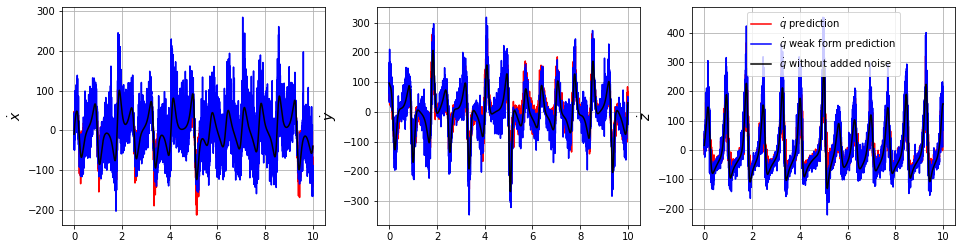

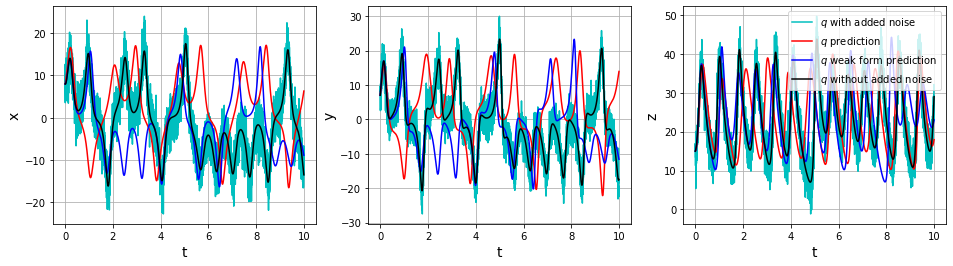

In [6]:
# Fit a weak form model
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    num_pts_per_domain=100,
    K=5000,
)
opt = ps.SR3(
    threshold=0.5, 
    thresholder="l0", 
    max_iter=10000, 
    normalize_columns=True, 
    tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train, quiet=True)
print("Weak form model: ")
model.print()

# Instantiate and fit a non-weak SINDy model
ode_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True,
)
optimizer = ps.SR3(
    threshold=0.5, 
    thresholder="l0", 
    max_iter=10000, 
    normalize_columns=True, 
    tol=1e-10
)
original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
original_model.fit(u_train, t=dt, quiet=True)
print("Regular model: ")
original_model.print()
err_not_weak = np.sqrt(
    (np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2) / np.sum(u_dot ** 2))
    / u_dot.shape[0]
)

u_pred = original_model.simulate(u0_test, t=t_train)
u_dot_pred = original_model.predict(u_test)

feature_names = ['x', 'y', 'z']
optimizer.coef_ = opt.coef_
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_dot_pred[:, i], "r", label=r"$\dot{q}$ prediction")
    plt.plot(t_train, u_dot_weak[:, i], "b", label=r"$\dot{q}$ weak form prediction")
    plt.plot(t_train, u_dot_clean[:, i], "k", label=r"$\dot{q}$ without added noise")
    plt.grid(True)
    plt.ylabel(r'$\dot{' + feature_names[i] + '}$', fontsize=14)
    if i == 2:
        plt.legend()

u_weak = original_model.simulate(u0_test, t=t_train)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], "c", label=r"$q$ with added noise")
    plt.plot(t_train, u_pred[:, i], "r", label=r"$q$ prediction")
    plt.plot(t_train, u_weak[:, i], "b", label=r"$q$ weak form prediction")
    plt.plot(t_train, u_clean[:, i], "k", label=r"$q$ without added noise")
    plt.grid(True)
    plt.ylabel(feature_names[i], fontsize=14)
    plt.xlabel('t', fontsize=14)
    if i == 2:
        plt.legend()

# Test weak form PDE functionality on Burgers' equation with 20% noise
Note that the weak formulation can be applied to PDEs too. 
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps. Although weak-formulation helps with noisy data, we also show that using smoothed finite-differences (or other more advanced differentiation schemes) can also improve robustness to noise.

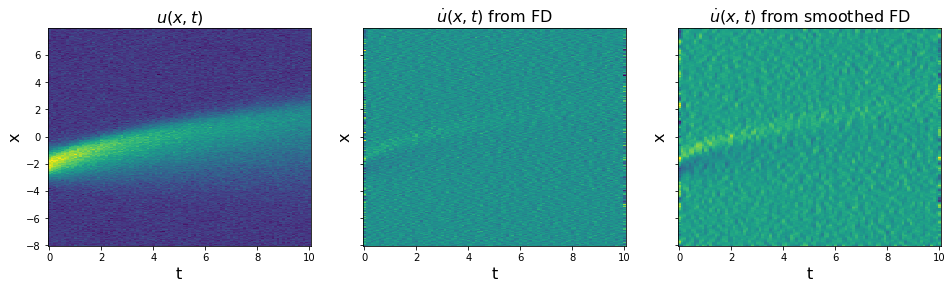

In [7]:
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from FD', fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from smoothed FD', fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [8]:
# Define weak form PDE library 
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

In [9]:
# Fit a weak form model
optimizer = ps.SR3(threshold=0.05, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 0.027 x0 + -0.085 x0x0 + 0.080 x0_11 + -0.979 x0x0_1


In [10]:
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        include_bias=False,
                        is_uniform=True)

# Fit and predict with the non-weak model
opt = ps.SR3(threshold=0.05, thresholder='l0', 
             tol=1e-10, normalize_columns=True, 
             max_iter=1000)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.011 x0 + -0.030 x0x0 + -0.018 x0x0_1 + -0.023 x0x0_11


The takeaway here is that the weak formulation drastically improved our system identification on the Burgers' equation with added noise. The weak formulation can handle even more than 20% noise here, although then a fairly large value for K is required to obtain a decent system identification. This is required for some of the examples below, and the downside is that this slows down the code considerably. 

# Test weak form PDE functionality on nonlinear diffusion with mixed function-derivative terms
Unlike the other PDE examples shown, this contains mixed terms like $uu_{xx}$, so this is a nice check the full PDE functionality works,
$$ u_ t = u u_{xx}.$$

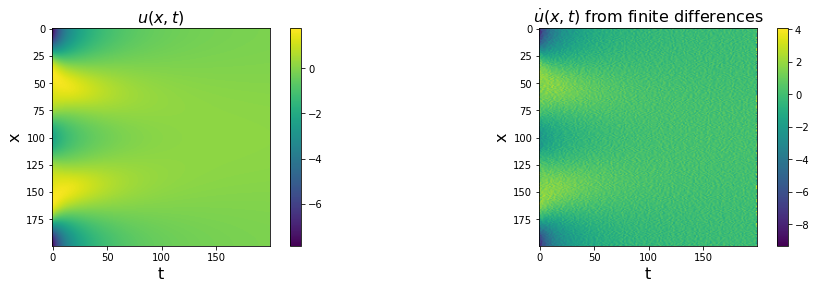

In [11]:
def diffuse (t, u, dx, nx):
    u = np.reshape(u, nx)
    du = ps.differentiation.SpectralDerivative(
            d=2, axis=0
         )._differentiate(u, dx)
    return np.reshape(u * du, nx)

N = 200
h0 = 1.0
L = 5
T = 1

t = np.linspace(0, T, N)
x = np.arange(0, N) * L / N

ep = 0.5 * h0
y0 = np.reshape(h0 + ep * np.cos(4 * np.pi / L * x) 
                + ep * np.cos(2 * np.pi / L * x), N)
dx = x[1] - x[0]

sol = solve_ivp(diffuse, (t[0], t[-1]), 
                y0=y0, t_eval=t, args=(dx, N),
                **integrator_keywords)

u_shaped_noiseless = np.reshape(sol.y, (N, N, 1))
u_dot_noiseless = ps.FiniteDifference(
    d=1, axis=1
)._differentiate(u_shaped_noiseless,t)

ep = 0.01 * np.min(sol.y)
u_shaped_noisy = u_shaped_noiseless + 2 * ep * (
    0.5 - np.random.random(size=(N, N, 1))
)
u_dot_noisy = ps.FiniteDifference(
    d=1, axis=1)._differentiate(u_shaped_noisy, t)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.imshow(u_dot_noiseless[:, :, 0])
plt.colorbar()
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(u_dot_noisy[:, :, 0])
plt.colorbar()
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
plt.title(r'$\dot{u}(x, t)$ from finite differences', fontsize=16)
plt.show()

#### Regular PDELibrary fails for noisy data!

In [12]:
library_functions = [
    lambda x: x,
]
library_function_names = [
    lambda x: x,
]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

np.random.seed(100)

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u_shaped_noiseless, 
          x_dot=np.reshape(u_dot_noiseless, (N ** 2, 1)))
model.print()

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u_shaped_noisy, 
          x_dot=np.reshape(u_dot_noisy, (N ** 2, 1)))
model.print()

(u)' = 1.000 uu_11
(u)' = -0.270 u


#### WeakPDELibrary works great for noisy data!

In [13]:
library_functions = [
    lambda x: x,
]
library_function_names = [
    lambda x: x,
]

X, T = np.meshgrid(x, t, indexing='ij')
XT = np.transpose([X, T], [1, 2, 0])
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    K=100,
    is_uniform=True,
    num_pts_per_domain=30,
)

np.random.seed(100)
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u_shaped_noiseless)
model.print()

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u'])
model.fit(u_shaped_noisy)
model.print()

(u)' = 1.018 uu_11
(u)' = 1.015 uu_11


# Test weak-formulation PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will skip noisy data for now, since we have already illustrated the pitfalls and performance with the weak form. We will revisit noisy data for the 2D reaction-diffusion example.

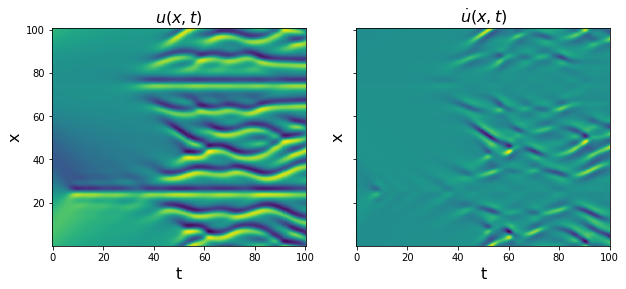

In [14]:
# Load and plot the data
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(time), 1)

In [15]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    H_xt=20,
    include_bias=True,
    is_uniform=True,
    K=200,
    num_pts_per_domain=200,
    include_interaction=True,
    periodic=True
)

In [16]:
# Run optimizers 
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.8, max_iter=1000,
    thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.2, max_iter=1000,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, 
                   kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = -0.917 x0_11 + -0.998 x0x0_1 + 0.002 x0x0x0_11 + 0.003 x0x0x0_1111
(x0)' = -1.002 x0_11 + -1.019 x0_1111 + -1.004 x0x0_1
(x0)' = -1.001 x0_11 + -1.015 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -0.917 x0_11 + -0.998 x0x0_1 + 0.002 x0x0x0_11 + 0.003 x0x0x0_1111
(x0)' = -0.925 x0_11 + -0.995 x0x0_1 + -0.002 x0x0x0_1 + 0.003 x0x0x0_11 + 0.003 x0x0x0_1111
(x0)' = -1.001 x0_11 + -0.001 x0_111 + -1.016 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


**Okay, so all the optimizers essentially capture the model but often have some much smaller "extra" terms.**
The best way to deal with these spurious terms is to use ensembling, i.e. the generation of many models by sub-sampling the data, or sub-sampling the SINDy candidate library. See notebook 13 for many examples of how to use these methods. 

You can also deal with this by scanning over the hyperparameters for each method although this is more laborious for the user. 

**Next we try the SR3 optimizer on the same data but with added noise of varying levels to illustrate the robustness to noisy data.**
Ideally, we would cross-validate over 10-20 noise instantiations, but with this high-dimensional data this can be computationally slow. We compute the coefficient model errors defined through
$$\Delta\xi_{u_{xx}} = \|\xi_{u_{xx}}^{true} - \xi_{u_{xx}}^{pred}\| / \|\xi_{u_{xx}}^{true}\| =  \|-1 - \xi_{u_{xx}}^{pred}\|,$$
and similarly for the other coefficients.

In [17]:
# Get average SR3 performance as function of the noise level.
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
    num_pts_per_domain=100,
)
optimizer = ps.SR3(
    threshold=0.5, max_iter=20, tol=1e-10, 
    thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy, quiet=True)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = -0.007 x0 + -1.083 x0_11 + -1.083 x0_1111 + -1.000 x0x0_1 + 0.003 x0x0x0_11 + 0.003 x0x0x0_1111
(x0)' = 0.004 x0 + -1.077 x0_11 + -1.081 x0_1111 + -1.006 x0x0_1
(x0)' = -0.001 x0x0 + -1.091 x0_11 + -1.087 x0_1111 + -1.007 x0x0_1 + 0.002 x0x0x0_11
(x0)' = 0.002 x0 + -1.084 x0_11 + 0.010 x0_111 + -1.086 x0_1111 + -0.992 x0x0_1 + 0.006 x0x0x0_1 + 0.002 x0x0x0_11
(x0)' = -0.006 x0_1 + -1.082 x0_11 + -1.083 x0_1111 + -1.003 x0x0_1 + -0.001 x0x0_11 + 0.001 x0x0x0_11


Now that we have computed the error in the model coefficients at each noise level, we plot the results.
We show below that the weak form nicely works for even 50% Gaussian noise added to every point, showing the power of the weak-formulation for robust system identification.

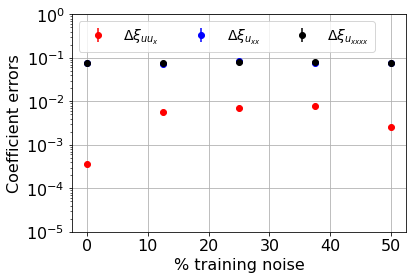

In [18]:
# Find mean and std over the validation runs
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c1_mean,
    yerr=delta_c1_std,
    color="r",
    fmt="o",
    label=r"$\Delta\xi_{uu_x}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c2_mean,
    yerr=delta_c2_std,
    color="b",
    fmt="o",
    label=r"$\Delta\xi_{u_{xx}}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c3_mean,
    yerr=delta_c3_std,
    color="k",
    fmt="o",
    label=r"$\Delta\xi_{u_{xxxx}}$",
)
plt.yscale("log")
plt.legend(
    fontsize=14, loc="upper left", ncol=3
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.xlabel('% training noise', fontsize=16)
plt.ylabel('Coefficient errors', fontsize=16)
plt.savefig("SR3_weakformPDE_KS.png")

# Test weak form PDE functionality on Reaction-Diffusion system
We now demonstrate another more advanced example - using the weak formulation of SINDy to robustly identify a 2D PDE.
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file. See the Example 10 Jupyter notebook for the non-weak-form system identification of the reaction-diffusion system.

Note that the Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold weak SINDy PRE paper uses 512 points in each direction. We will try and get away with only 64 points in each direction for speed (with normal PDE-FIND this would be a liability because the high order derivatives are very noisy), and still show robustness to ~ 10% noise levels

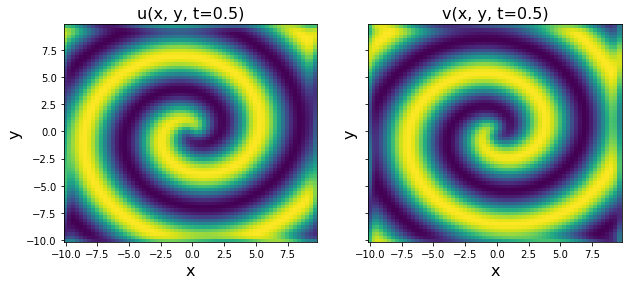

In [44]:
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, 
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.1))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                  np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), 
         np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, 
    (t[0], t[-1]), 
    y0=uvt0, 
    t_eval=t, 
    args=(K22, d1, d2, beta, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [45]:
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
#     H_xt=[4,4,2],
    periodic=True,
    K=100
)

In [46]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 0.699 x0 + 0.403 x1 + -0.634 x0x0x0 + 0.547 x1x1x1 + -0.638 x0x1x1 + 0.558 x0x0x1 + 0.083 x0_22 + 0.080 x0_11 + -0.468 x0x0x0x0_2 + -0.467 x0x1x1x1_2 + 0.495 x1x1x1x1_12 + -0.558 x0x1x1x1_12 + -0.522 x0x0x1x1_12
(x1)' = -0.222 x0 + 0.880 x1 + -0.750 x0x0x0 + -0.822 x1x1x1 + -0.760 x0x1x1 + -0.834 x0x0x1 + 0.090 x1_22 + 0.088 x1_11 + 0.177 x0x1_1 + -0.198 x1x1_1 + 0.179 x1x1x1x0_1 + -0.197 x0x1x1x0_1 + -0.797 x0x1_12 + 0.921 x1x1_12 + 0.846 x0x0x0x1_12


Okay, so we have captured the essential terms in the clean data case... can we repeat with some added noise?

In [48]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=800,
#     H_xt=[4,4,2],
    is_uniform=True,
    periodic=True
)

# Initialize noisy data
rmse = mean_squared_error(u.flatten(), np.zeros(u.size), squared=False)
u_noisy = u + np.random.normal(0, rmse / 50.0, u.shape)  # Add 2% noise

# Fit the 2D reaction-diffusion equation with noise, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u_noisy, quiet=True)
model.print()

(x0)' = 0.741 x0 + 0.312 x1 + -0.687 x0x0x0 + 0.651 x1x1x1 + -0.693 x0x1x1 + 0.654 x0x0x1 + 0.077 x0_22 + 0.078 x0_11 + 0.042 x0x0_2 + 0.039 x1x1x1x1_2 + 0.048 x0x1_1 + -0.058 x1x1_1 + -0.103 x0x0x0x1_1 + -0.058 x1x1x1x0_1 + 0.066 x0x1x1x0_1
(x1)' = -0.314 x0 + 0.724 x1 + -0.649 x0x0x0 + -0.671 x1x1x1 + -0.653 x0x1x1 + -0.666 x0x0x1 + 0.076 x1_22 + 0.078 x1_11 + -0.079 x0x0_2 + -0.073 x0x1_2 + 0.091 x1x0_2 + 0.080 x1x1_2 + 0.090 x0x0x0x0_2 + -0.075 x1x1x1x0_2 + -0.095 x1x1x1x1_2 + 0.083 x0x1x1x0_2 + 0.110 x0x1x1x1_2 + 0.106 x0x0x1x1_2


The weak formulation works adequately with noise, but requires a relatively large K and takes some time!

# Test weak form PDE functionality on 3D Reaction-Diffusion system
Can even use weak-form for 3D PDEs although this is getting computationally intensive! 

We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810. ([Link](https://arxiv.org/pdf/1907.07810.pdf)).
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some low-resolution data, because the memory requirements are very significant for a fully 3D problem. We can still get a pretty good model.

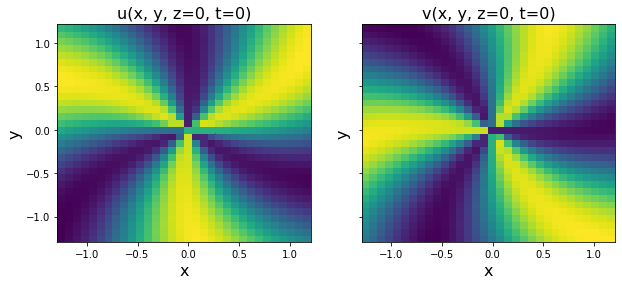

In [30]:
from numpy.fft import fftn, ifftn

# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, 
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
dt = 0.1
t = np.linspace(0, 10, int(10 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions
n = 32  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                  np.linspace(-n2, -1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
K2 = KX ** 2 + KY ** 2 + KZ ** 2
K22 = np.reshape(K2, (N, 1))

m = 3  # number of spirals

# define our solution vectors
u = np.zeros((n, n, n, len(t)))
v = np.zeros((n, n, n, len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)
v[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (
            np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
            np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
        )
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, 
    (t[0], t[-1]), 
    y0=uvt0, 
    t_eval=t, 
    args=(K22, d1, d2, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, z=0, t=0)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, z=0, t=0)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [38]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=3)._differentiate(u, dt)

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z, T = np.meshgrid(x, y, z, time, indexing="ij")
spatiotemporal_grid = np.asarray([X, Y, Z, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    num_pts_per_domain=20,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    H_xt=[L/4,L/4,L/4,1]
)

In [41]:
# Fit the 3D reaction-diffusion equation
optimizer = ps.SR3(threshold=1e-4, normalize_columns=True, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 0.014 1 + -0.011 x0 + 0.020 x0x0x0 + 0.009 x1x1x1 + -1.051 x0x1x1 + 0.062 x0x0x1 + 0.017 x0_33 + 0.002 x1_33 + 0.020 x0_22 + 0.020 x0_11
(x1)' = -0.065 x1 + 0.002 x1x1x1 + 0.995 x0x1x1 + 0.011 x1_33 + 0.010 x1_22 + 0.010 x1_11


In [ ]:
stop=timeit.default_timer()
print(stop-start)

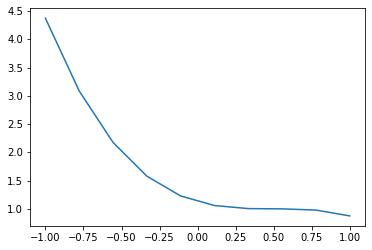

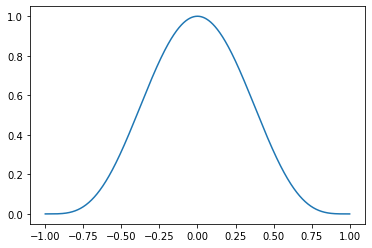

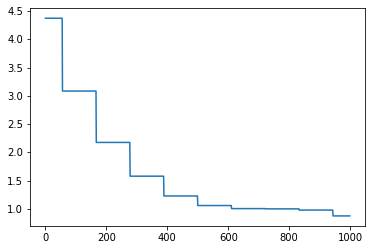

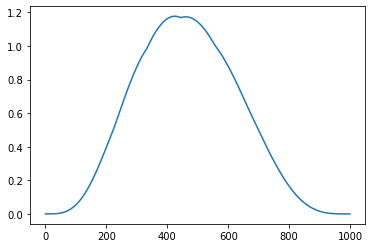

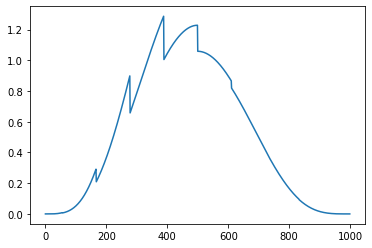

In [321]:
#Test integration
func=lambda x: 1-(x-0.5)**3

x=np.linspace(-1,1,10)
phi=(x**2-1)**4
f=func(x)
plt.plot(x,f)
plt.show()

x2=np.linspace(-1,1,1000)
phi2=(x2**2-1)**4
f2=func(x2)
plt.plot(x2,phi2)
plt.show()

from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid

fint=RegularGridInterpolator([x],f,method='nearest')
fint2=RegularGridInterpolator([x],f,method='linear')

plt.plot(fint(x2))
plt.show()

plt.plot(phi2*fint2(x2))
plt.show()

plt.plot(phi2*fint(x2))
plt.show()



In [287]:
#We can successfully replace the fine mesh nearest and linear interpolated integral with a vectorized product!
p=4
from scipy.special import hyp2f1

weights=np.concatenate([[(-1)**4*(x[1]+x[0])/2*hyp2f1(0.5,-4,1.5,((x[1]+x[0])/2)**2)-(-1)**4*(x[0])*hyp2f1(0.5,-4,1.5,x[0]**2)],
                     (-1)**4*(x[2:]+x[1:-1])/2*hyp2f1(0.5,-4,1.5,((x[2:]+x[1:-1])/2)**2)-(-1)**4*(x[1:-1]+x[:-2])/2*hyp2f1(0.5,-4,1.5,((x[1:-1]+x[:-2])/2)**2),
                     [(-1)**4*(x[-1])*hyp2f1(0.5,-4,1.5,x[-1]**2)-(-1)**4*(x[-1]+x[-2])/2*hyp2f1(0.5,-4,1.5,((x[-1]+x[-2])/2)**2)]])

w=lambda x:  (-1)**p*x*hyp2f1(0.5,-p,1.5,x**2)
z=lambda x: (x**2-1)**(p+1) / (2*(p+1))
ws=w(x)
zs=z(x)
linear_weights=np.concatenate([[x[1]/(x[1]-x[0])*(ws[1]-ws[0])-1/(x[1]-x[0])*(zs[1]-zs[0])],
                        [x[k+1]/(x[k+1]-x[k])*(ws[k+1]-ws[k])-x[k-1]/(x[k]-x[k-1])*(ws[k]-ws[k-1]) 
         + 1/(x[k]-x[k-1])*(zs[k]-zs[k-1])-1/(x[k+1]-x[k])*(zs[k+1]-zs[k]) for k in range(1,len(x)-1)],
                        [-x[-2]/(x[-1]-x[-2])*(ws[-1]-ws[-2])+1/(x[-1]-x[-2])*(zs[-1]-zs[-2])]])

print(trapezoid(phi2*fint2(x2),x=x2), linear_weights@f)
print(trapezoid(phi2*fint(x2),x=x2), weights@f)
print(trapezoid(f*phi,x=x))

0.5289538772507708 0.5289533343464342
0.5322928945182158 0.5322926237434371
0.5356079240606499


In [288]:
#The weights are faster than both interpolated and coarse trapezoids!
start=timeit.default_timer()
trapezoid(phi2*fint(x2),x=x2)
stop=timeit.default_timer()
print(stop-start)
start=timeit.default_timer()
trapezoid(f*phi,x=x)
stop=timeit.default_timer()
print(stop-start)
start=timeit.default_timer()
weight@f
stop=timeit.default_timer()
print(stop-start)
start=timeit.default_timer()
linear_weights@f
stop=timeit.default_timer()
print(stop-start)


0.0005304040023474954
0.00011048400119761936
5.715799852623604e-05
5.078700269223191e-05


In [322]:
from scipy.special import hyp2f1
from scipy.special import poch

def phi(x,d,p):
    return (2 * x) ** d * (x ** 2 - 1) ** (p - d) * hyp2f1((1 - d) / 2.0, -d / 2.0, p + 1 - d, 1 - 1 / x ** 2) * poch(p + 1 - d, d)

def w(x,d,p):
    if d==0:
        return (-1)**p*x*hyp2f1(0.5,-p,1.5,x**2)
    else:
        return phi(x,d-1,p)
    
def z(x,d,p):
    if d==0:
        return (x**2-1)**(p+1) / (2*(p+1))
    elif d==1:
        return -(2.0/3.0) * (-1)**p * p * x**3 * hyp2f1(3.0/2.0, 1-p, 5.0/2.0, x**2)
    else:
        return x*phi(x,d-1,p)-phi(x,d-2,p)
    
def linear_weights(x,d,p):
    ws = w(x,d,p)
    zs = z(x,d,p)
    return np.concatenate([[x[1]/(x[1]-x[0])*(ws[1]-ws[0])-1/(x[1]-x[0])*(zs[1]-zs[0])],
                           [x[k+1]/(x[k+1]-x[k])*(ws[k+1]-ws[k])-x[k-1]/(x[k]-x[k-1])*(ws[k]-ws[k-1]) 
                            + 1/(x[k]-x[k-1])*(zs[k]-zs[k-1])-1/(x[k+1]-x[k])*(zs[k+1]-zs[k]) for k in range(1,len(x)-1)], #can use list slicing here...
                           [-x[-2]/(x[-1]-x[-2])*(ws[-1]-ws[-2])+1/(x[-1]-x[-2])*(zs[-1]-zs[-2])]])

p=4
phi2_0 = (x2**2-1)**p
phi2_1 = 2 * p * x2 * (x2**2-1)**(-1+p) 
phi2_2 = 4 * (-1 + p) * p * x2**2 * (-1 + x2**2)**(-2 + p) + 2 * p * (-1 + x2**2)**(-1 + p)
phi2_3 = 8 * (-2+p) * (-1+p) * p * x2**3 * (-1+x2**2)**(-3+p)+12 * (-1+p) * p * x2 * (-1+x2**2)**(-2+p)

print(trapezoid(phi2_0*fint2(x2),x=x2),f@linear_weights(x,0,p))
print(trapezoid(phi2_1*fint2(x2),x=x2),f@linear_weights(x,1,p))
print(trapezoid(phi2_2*fint2(x2),x=x2),f@linear_weights(x,2,p))
print(trapezoid(phi2_3*fint2(x2),x=x2),f@linear_weights(x,3,p))

1.0351406126952725 1.0351414270517774
0.8512180502562958 0.8512196835169668
2.4381858279613287 2.4381858028164314
4.88963060731891 4.890073555195969


In [ ]:
# In setup_grids, pre-calculate the linear weights for each domain along each axis.
# Just restrict the domains to the nearest grid point and resize to H_xt_k

# Worry about the mixed derivative terms later
# Vectorization of the products over all axes and domains would also be possible later